# Importación de Librerías

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score
from src.processing.constants import BASE_DIRECTORY
from typing import Dict
from typing import List
from text_complexity_analyzer_cm.text_complexity_analyzer import TextComplexityAnalyzer

%matplotlib inline

# Funciones de ayuda

In [2]:
def get_epoch_from_line(line: str) -> int:
    '''
    This function gets an epoch from a line of the text.
    
    Parameters:
    line(str): The line of the text.
    
    Returns:
    int: The epoch.
    '''
    return int(line.split()[1].split('/')[0])

In [3]:
def get_training_loss_from_line(line: str) -> float:
    '''
    This function gets the training loss from a line.
    
    Parameters:
    line(str): The line of the text.
    
    Returns:
    float: The training loss.
    '''
    words = line.split()
    training_loss_str = words[11]
    return float(training_loss_str[:-1])

In [4]:
def get_validation_loss_from_line(line: str) -> float:
    '''
    This function gets the validation loss from a line.
    
    Parameters:
    line(str): The line of the text.
    
    Returns:
    float: The validation loss.
    '''
    words = line.split()
    validation_loss_str = words[4]
    return float(validation_loss_str[:-1])

In [5]:
def get_training_validation_loss(filename: str, epochs: int) -> (List, List):
    '''
    This function obtains, from a text file, the validation and training lost.
    
    Parameters:
    filename(str): The file where the training log of the chatbot is found.
    epochs(str): The amount of epochs that were used to train the chatbot.
    
    Returns:
    List, List: A list with the training loss and another with the validaiton loss.
    '''
    training_loss = [0] * epochs
    validation_loss = [0] * epochs
    with open(filename, 'r') as f: # Open the file with the training data
        # Iterate every line
        for line in f:
            if 'Training Loss:' in line: # Get training loss
                epoch = get_epoch_from_line(line) # Get epoch
                training_loss[epoch - 1] = get_training_loss_from_line(line) # Store loss in list
            elif 'Validation loss:' in line: # Get validation loss
                epoch = get_epoch_from_line(line) # Get epoch)
                validation_loss[epoch - 1] = get_validation_loss_from_line(line) # Store loss in list
    
    return pd.DataFrame(data={
    'training': training_loss,
    'validation': validation_loss
    })

In [6]:
def obtain_chatbot_responses(filename: str) -> List[str]:
    '''
    This function reads the log file for the chatbot conversation and obtains the responses given by the chatbot and stores it in an array.
    
    Parameters:
    filename(str): The filename that holds the chatbot conversation.
    
    Returns:
    List[str]: The list with the chatbot's responses.
    '''
    responses = []
    with open(filename, 'r') as f:
        # Read each line
        for line in f:
            # Chatbot response
            if 'ChatBot:' in line:
                tokens = line.split('ChatBot:')
                responses.append(tokens[-1].strip())
    
    return responses

In [7]:
def calculate_chatbots_responses_cm_indices(responses: List[str]) -> Dict:
    '''
    This function calculates the coh metrix indices for the responses given by the chatbot.
    
    Parameters:
    responses(List[str]): A list with the chatbot's responses.
    
    Returns:
    Dict: Dictionary that contains 8 Pandas' dataframes that contains each group of coh metrix indices. 
    '''
    tca = TextComplexityAnalyzer('es')
    indices = {}
    indices['Descriptivo'] = pd.DataFrame()
    indices['Legibilidad'] = pd.DataFrame()
    indices['Información de palabras'] = pd.DataFrame()
    indices['Densidad de patrones sintácticos'] = pd.DataFrame()
    indices['Complejidad sintáctica'] = pd.DataFrame()
    indices['Diversidad léxica'] = pd.DataFrame()
    indices['Cohesión referencial'] = pd.DataFrame()
    indices['Conectivos'] = pd.DataFrame()
    indices['Complejidad textual'] = pd.DataFrame()
    # Iterate over all responses up to a certain point
    for i in range(len(responses)):
        # Gather all responses up until i + 1 and join them in a single string.
        responses_joined = '.\n'.join(responses[:i + 1])
        descriptive, word_information, syntactic_pattern, syntactic_complexity, connective, lexical_diversity, readability, referential_cohesion = tca.calculate_all_indices_for_one_text(text=responses_joined, workers=-1)
        # APpend results to dataframes
        indices['Descriptivo'] = indices['Descriptivo'].append(descriptive, ignore_index=True)
        indices['Legibilidad'] = indices['Legibilidad'].append(readability, ignore_index=True)
        indices['Información de palabras'] = indices['Información de palabras'].append(word_information, ignore_index=True)
        indices['Densidad de patrones sintácticos'] = indices['Densidad de patrones sintácticos'].append(syntactic_pattern, ignore_index=True)
        indices['Complejidad sintáctica'] = indices['Complejidad sintáctica'].append(syntactic_complexity, ignore_index=True)
        indices['Diversidad léxica'] = indices['Diversidad léxica'].append(lexical_diversity, ignore_index=True)
        indices['Cohesión referencial'] = indices['Cohesión referencial'].append(referential_cohesion, ignore_index=True)
        indices['Conectivos'] = indices['Conectivos'].append(connective, ignore_index=True)
        indices['Complejidad textual'] = indices['Complejidad textual'].append({
            'Categoria': tca.predict_text_category(text=responses_joined, workers=-1)[-1]
        }, ignore_index=True)
    
    return indices

In [8]:
def draw_indices(indices: Dict) -> None:
    '''
    This funciton draws all the indices using lineplots and a boxplot for the predictions.
    
    Parameters:
    indices(Dict): Dictionary that containes the 8 pandas dataframes with the indices.
    
    Returns:
    None.
    '''
    # Iterate over all keys from the dictionary
    for key in indices.keys():
        # Draw figure
        plt.figure(figsize=(15, 7))
        if key != 'Complejidad textual':
            sns.lineplot(data=indices[key])
            plt.title(f'Indices {key}')
            plt.ylabel('Valor de índice')
            plt.xlabel('Cantidad de respuestas de chatbot')
        else:
            sns.countplot(x='Categoria', data=indices[key])
            plt.ylabel('Cantidad')
            plt.xlabel('Categoría')
            plt.title(key)
        
    plt.show()

In [9]:
def predicted_text_statistic_analysis(textual_complexity: int, predictions: pd.DataFrame) -> None:
    '''
    This function will run an experiment to determine whether or not the textual complexity of the chatbot generated text corresponds to its supposed textual complexity.
    
    Paramters:
    textual_complexity(int): The textual complexity the answers should have.
    predictions(pd.DataFrame): A DataFrame with the classes predicted by the textual complexity analysis tool.
    
    Returns:
    None.
    '''
    total_mean = predictions.describe().iloc[1, 0] # Get the mean of the predictions
    total_mode = int(predictions.astype('object').describe().iloc[2,0]) # Get the mode of the predictions
    unique_values = pd.unique(predictions.iloc[:, 0]) # Find unique values of the predictions: 1 and 2
    values_mean = unique_values.mean()
    expected_values = [textual_complexity for i in range(predictions.shape[0])] # Create an ñost with the expected predictions of the responses.
    accuracy = accuracy_score(expected_values, predictions['Categoria']) * 100
    print(f'La exactitud de la complejidad textual generada es {accuracy}%.')
    # Since we only have two classes, if the mean of all the predictions is below the mean of the unique values, then the majority of the predictions belong to class 1, else, they belong to class 2
    if total_mean < values_mean:
        print(f'La media {total_mode} es menor a {values_mean}. Eso significa que las respuestas generadas son en su mayoría de complejidad textual 1.')
        if total_mode == textual_complexity: # Analiza la moda
            print(f'La moda es {total_mode}, la cual corresponde a la complejidad textual {textual_complexity} del texto con el que se entreno al chatbot.')
        else:
            print(f'La moda es {total_mode}, la cual no corresponde a la complejidad textual {textual_complexity} del texto con el que se entreno al chatbot.')
    elif total_mean > values_mean:
        print(f'La media {total_mode} es mayor a {values_mean}. Eso significa que las respuestas generadas son en su mayoría de complejidad textual 2.')
        if total_mode == textual_complexity:
            print(f'La moda es {total_mode}, la cual corresponde a la complejidad textual {textual_complexity}.')
        else:
             print(f'La moda es {total_mode}, la cual no corresponde a la complejidad textual {textual_complexity} del texto con el que se entreno al chatbot.')
    else:
        print(f'La media {total_mode} es igual a {values_mean}. Eso significa que las respuestas generadas son de igual manera complejas y simples.')

# Experimento usando los documentos de Comunicación

## En nivel de complejidad 1

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [10]:
losses = get_training_validation_loss(f'{BASE_DIRECTORY}/data/raw/log_grade_1_comunicacion.txt', 100)
losses.describe()

,training,validation
count,100.000000,100.00000
mean,4.314820,5.77039
std,1.653443,0.61464
min,1.663000,5.00100
25%,2.829750,5.17725
50%,4.183000,5.56550
75%,5.905250,6.42525
max,6.971000,6.83500


In [11]:
losses.iloc[1,:]['training']

6.808

#### Curva de error: Capacidad de comprensión

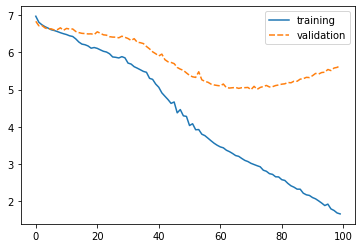

In [12]:
sns.lineplot(data=losses)
plt.show()

Luego de haber entrenado el chatbot se observa que la curva de error de la métrica Perplexity, sigue valores similares para el conjunto de datos de prueba y validación hasta aproximadamente la época 50, sin emargo, esta métrica luego empieza a separarse. Eso significa que el chatbot puede no reconocer oraciones nuevas que puede los usuarios y no generar una respuesta adecuada, aunque sea capaz de reconocer bien oraciones conocidas, debido al bajo valor del error en el entrenamiento.

#### Obteniendo las respuestas del chatbot

In [13]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_1_comunicacion_chat.txt')
print(chatbot_responses)

['que es lo que más le gusta hacer', 'comunicacion en grupo el objeto en la página en nuestro cuaderno o en nuestro cd', 'en qué trata del texto', 'qué tipo de texto voy a leer', 'cómo se sintieron la actitud', 'paso o m u n n a c ió n el texto de manera silenciosa', 'oralmente oralmente oralmente', 'ubicar qué puedes hacer para aprender lo que te faltó', 'comunicacion en esta actividad aprenderemos lo siguiente qué aprenderemos en esta actividad', 'comunicacion qué aprendimos en esta unidad', 'qué tipo de texto vamos a escribir', 'con su profesora o profesor y sus compañeras y compañeros', 'comunicacion leemos los acuerdos de convivencia que necesitamos para trabajar en grupo', 'd o m u n ic a c ió n el siguiente esquema', 'oralmente la situación', 'lo que dice esteban y respondan las preguntas', 'comunicacion', 'para qué voy a escribir este texto', 'qué tipo de texto vamos a leer', 'comunicacion qué tipo en esta unidad']


#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [14]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

Text analyzed in 5.083858489990234 seconds.
Text analyzed in 5.198656797409058 seconds.
Text analyzed in 5.773060321807861 seconds.
Text analyzed in 7.670210838317871 seconds.
Text analyzed in 7.1387152671813965 seconds.
Text analyzed in 6.112358331680298 seconds.
Text analyzed in 6.21634316444397 seconds.
Text analyzed in 5.406440019607544 seconds.
Text analyzed in 6.040239095687866 seconds.
Text analyzed in 5.839293479919434 seconds.
Text analyzed in 5.796955347061157 seconds.
Text analyzed in 5.8044304847717285 seconds.
Text analyzed in 5.375593900680542 seconds.
Text analyzed in 5.4572155475616455 seconds.
Text analyzed in 6.080411911010742 seconds.
Text analyzed in 6.1897265911102295 seconds.
Text analyzed in 5.570470094680786 seconds.
Text analyzed in 5.326028823852539 seconds.
Text analyzed in 6.508907318115234 seconds.
Text analyzed in 5.6769020557403564 seconds.
Text analyzed in 6.22637939453125 seconds.
Text analyzed in 6.267439842224121 seconds.
Text analyzed in 5.3846180438

#### Graficando los índices y complejidad textual

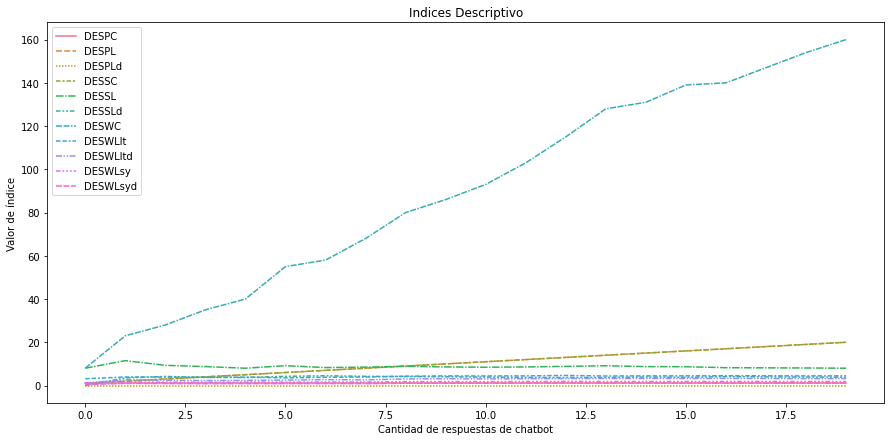

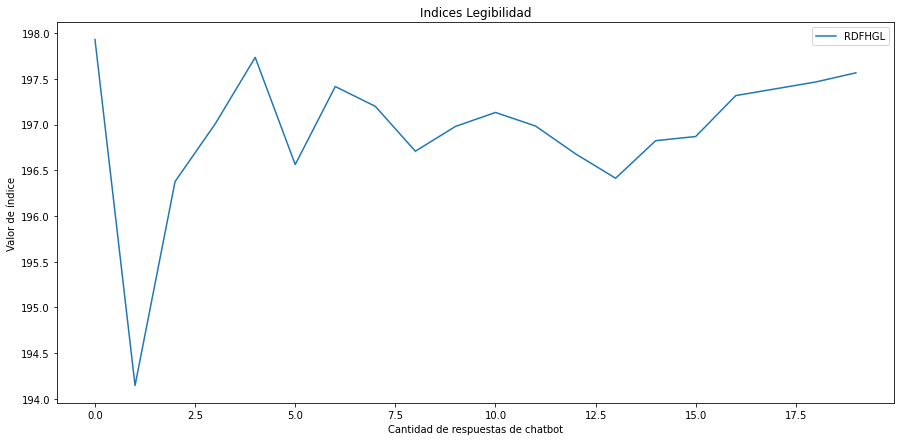

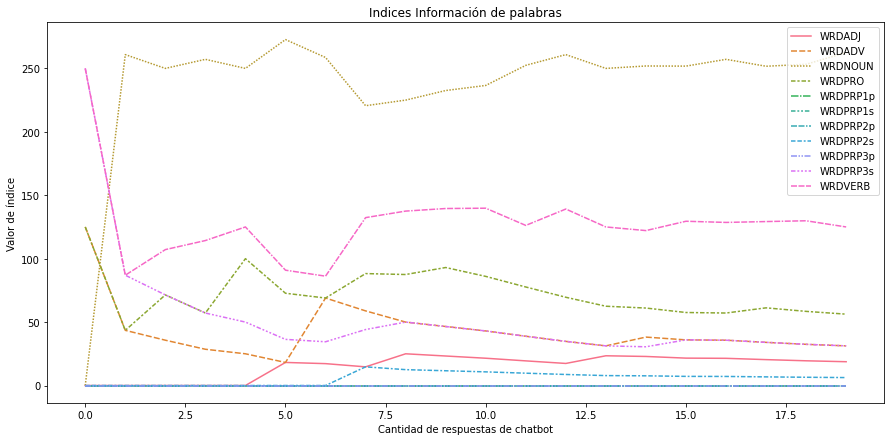

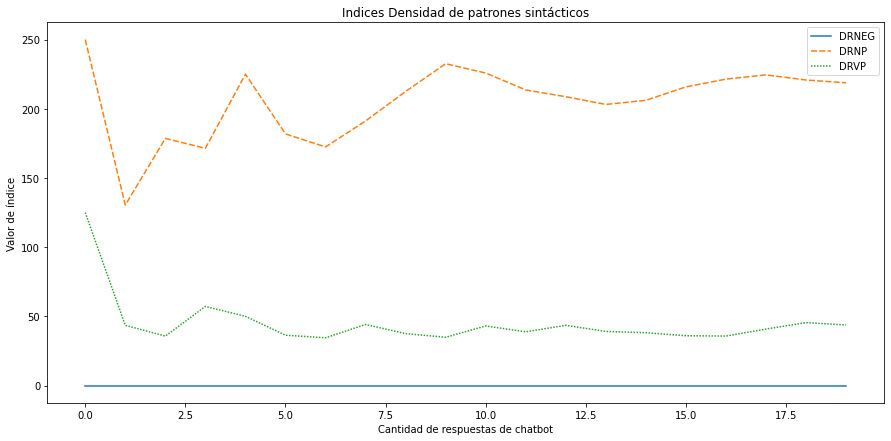

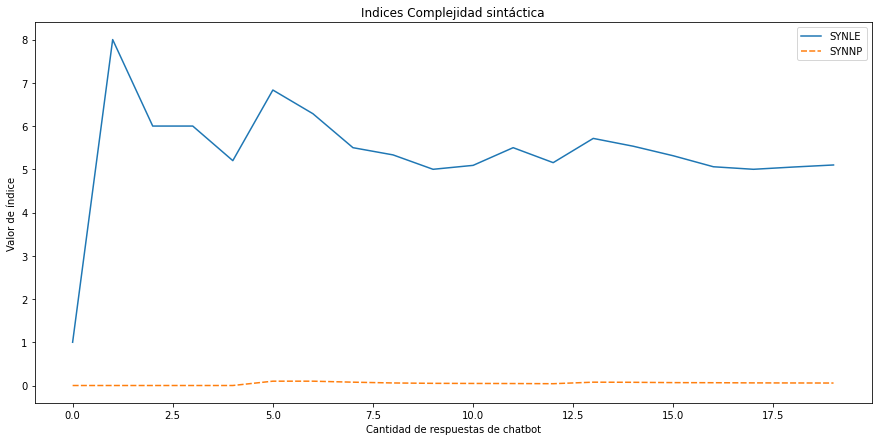

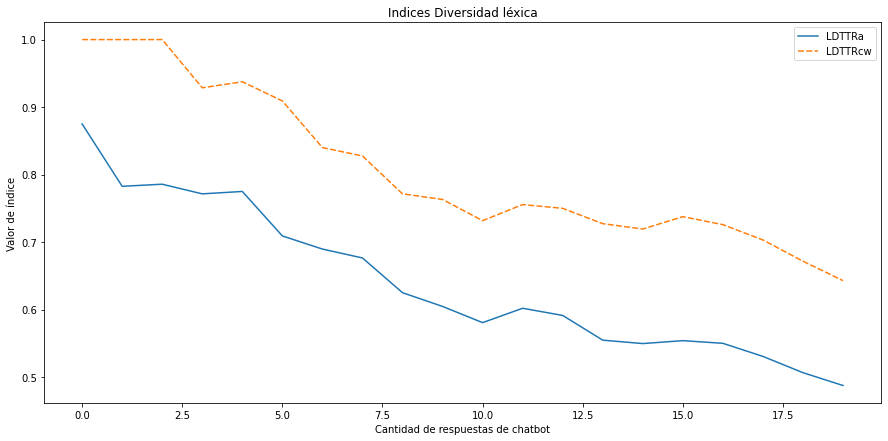

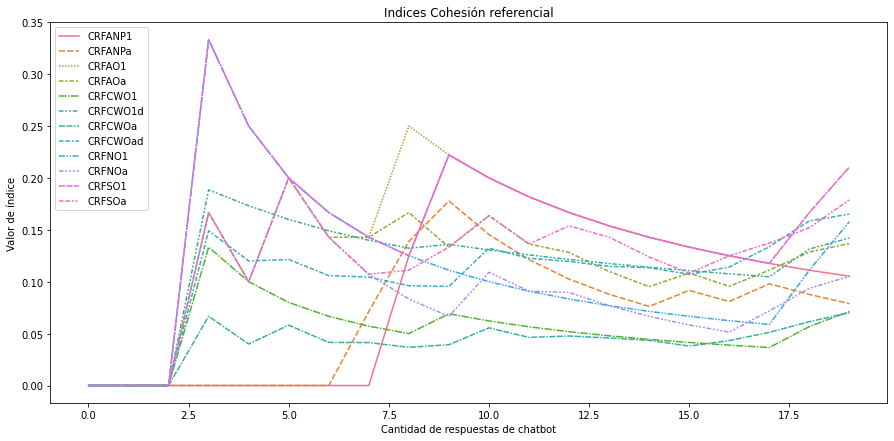

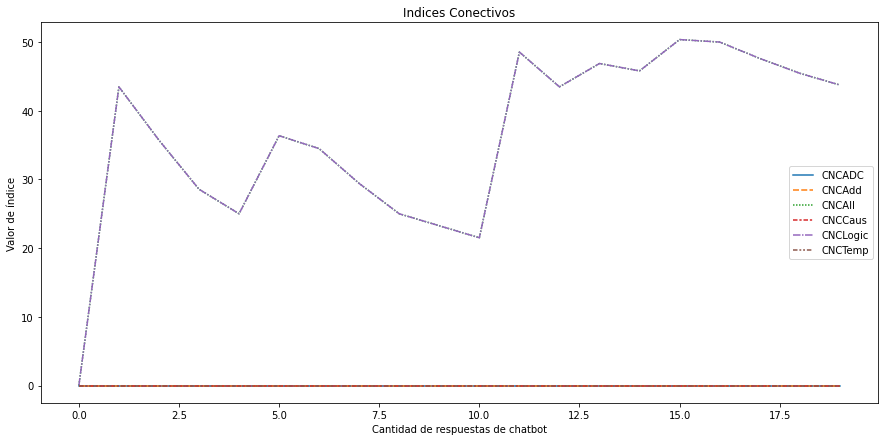

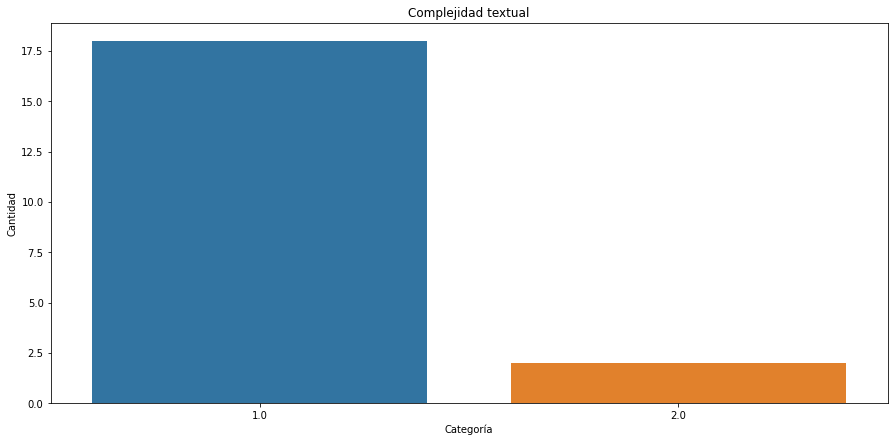

In [15]:
draw_indices(indices)

In [16]:
predicted_text_statistic_analysis(1, indices['Complejidad textual'])

La exactitud de la complejidad textual generada es 90.0%.
La media 1 es menor a 1.5. Eso significa que las respuestas generadas son en su mayoría de complejidad textual 1.
La moda es 1, la cual corresponde a la complejidad textual 1 del texto con el que se entreno al chatbot.


Se observa que la mayoría de las clases predichas, usando la moda como análisis, es 1, la cual es la la complejidad textual más simple y ello se debe a que el conjunto de datos con el que se entrenó tuvo una complejidad textual de 1. Con ello, se verifica que el chatbot está produciendo respuestas adecuadas al nivel de complejidad deseado para este conjunto de datos.

## En nivel de complejidad 2

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [17]:
losses = get_training_validation_loss(f'{BASE_DIRECTORY}/data/raw/log_grade_2_comunicacion.txt', 100)
losses.describe()

,training,validation
count,100.000000,100.000000
mean,6.081490,6.905260
std,0.801106,0.550008
min,4.635000,6.283000
25%,5.373000,6.573000
50%,6.162000,6.889500
75%,6.903750,7.132000
max,7.290000,10.062000


#### Curva de error: Capacidad de comprensión

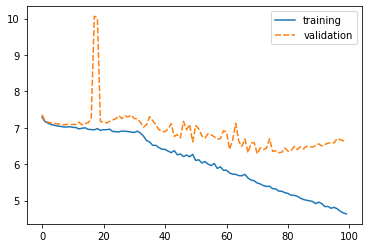

In [18]:
sns.lineplot(data=losses)
plt.show()

En este caso se observa para la curva de pérdida que los valores para ambas métricas son más parecidas que cuando el chatbot fue entrenado con el conjunto de datos de complejidad textual 1, el cual era un conjunto de datos más pequeños. Debido a la mayor riqueza del vocabulario, se pudo lograr un mejor resultado en cuanto a la comprensión del chatbot. Esto significa que, con el presente conjunto de entrenamiento, el chatbot tendrá una mejor capacidad de comprensión que con el conjunto de datos anterior y podría brindar mejores respuestas. 

#### Obteniendo las respuestas del chatbot

In [19]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_2_comunicacion_chat.txt')
print(chatbot_responses)

['lo que no no es más que es que mi es es que puede que no era más que el mundo de hielo y no me ha hecho a', 'el director de la compañía no está usted lo que usted', 'el director de la compañía eso no es lo que es usted lo que has oído', 'y por qué se había de presentar en el motivo no es nada que la víspera sábado fecha fecha del de diciembre a las ocho y cuarenta y cinco minutos', 'en el tiempo de la noche y lo mejor era posible de lo que decía y me decía y me decía de mi modo y de lo cual no te', 'el director de la compañía pero no he dicho a usted también también no quiero lo que a él', 'y por qué no la posadera', 'el director de la compañía eso no es muy remedio', 'y por qué se había de presentar en el colegas no lo esperaban puesto que la víspera sábado fecha fatal del de diciembre a las ocho y cuarenta y cinco', 'el director de la compañía en el día en la noche de la compañía le hallaba y las horas se habían apoderado a la vez siguiente al menos de la noche', 'el director de la

#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [20]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

Text analyzed in 7.6432507038116455 seconds.
Text analyzed in 5.925514459609985 seconds.
Text analyzed in 5.700615882873535 seconds.
Text analyzed in 6.446480751037598 seconds.
Text analyzed in 5.736673831939697 seconds.
Text analyzed in 5.841407537460327 seconds.
Text analyzed in 6.067476511001587 seconds.
Text analyzed in 6.560253381729126 seconds.
Text analyzed in 5.974015951156616 seconds.
Text analyzed in 5.556635618209839 seconds.
Text analyzed in 6.074899435043335 seconds.
Text analyzed in 5.5030364990234375 seconds.
Text analyzed in 7.9196600914001465 seconds.
Text analyzed in 7.697013854980469 seconds.
Text analyzed in 6.33831787109375 seconds.
Text analyzed in 6.097604513168335 seconds.
Text analyzed in 5.575013160705566 seconds.
Text analyzed in 5.759268283843994 seconds.
Text analyzed in 6.290530204772949 seconds.
Text analyzed in 5.906927108764648 seconds.
Text analyzed in 6.190753936767578 seconds.
Text analyzed in 6.740519285202026 seconds.
Text analyzed in 7.63365602493

#### Graficando los índices y complejidad textual

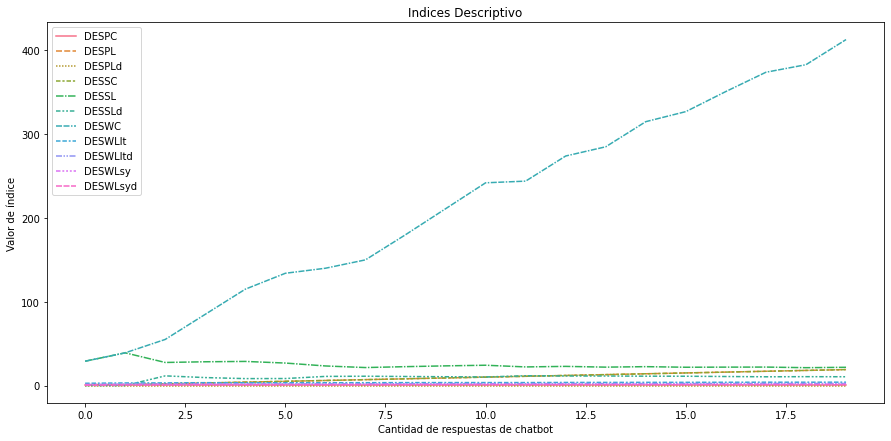

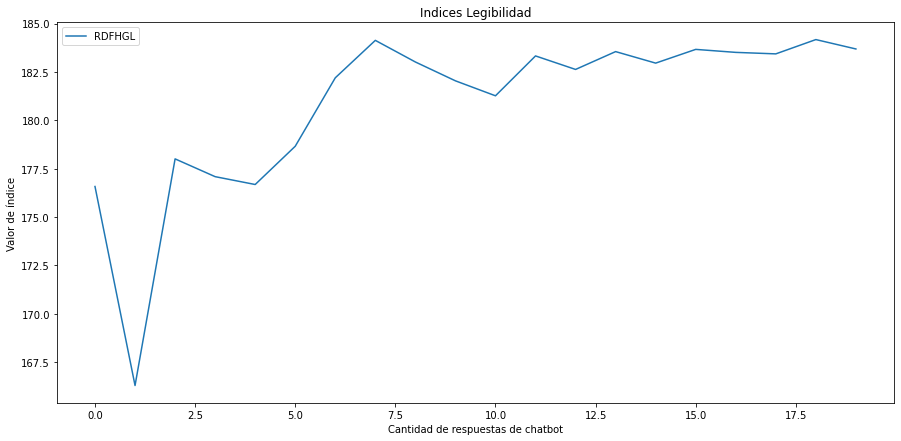

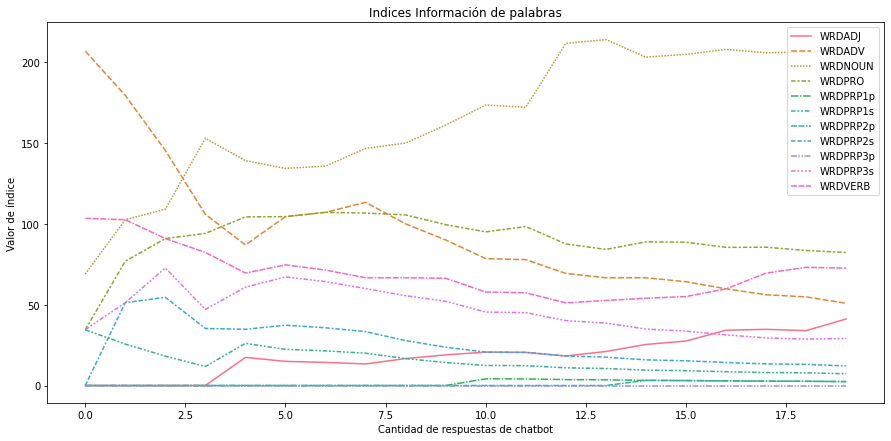

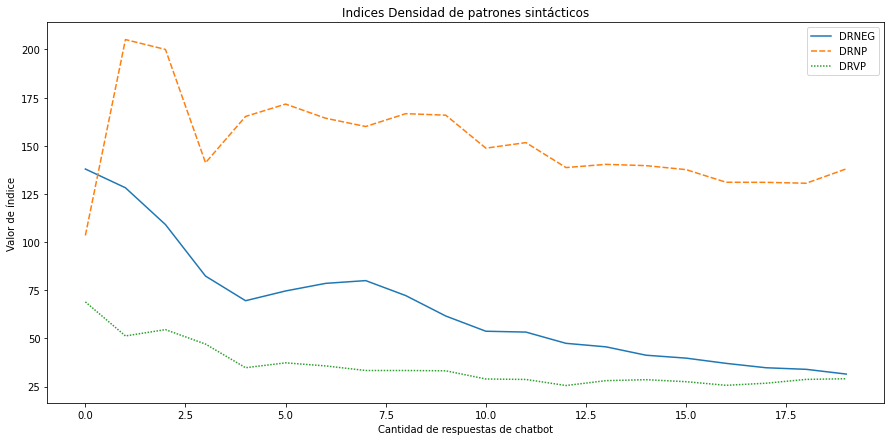

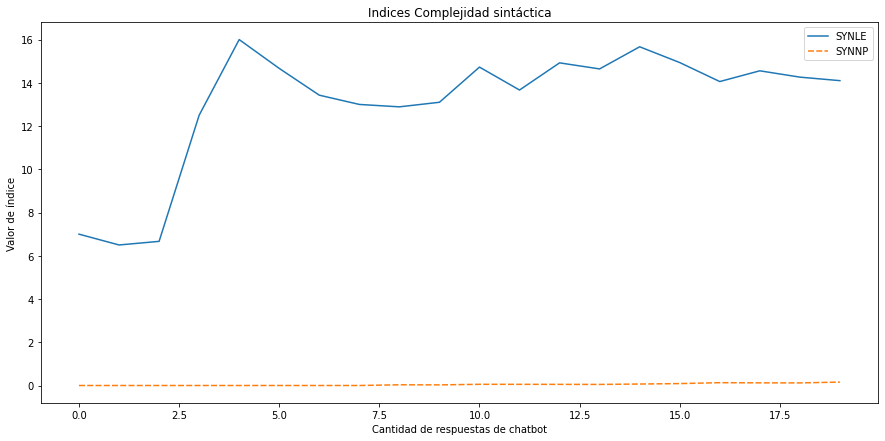

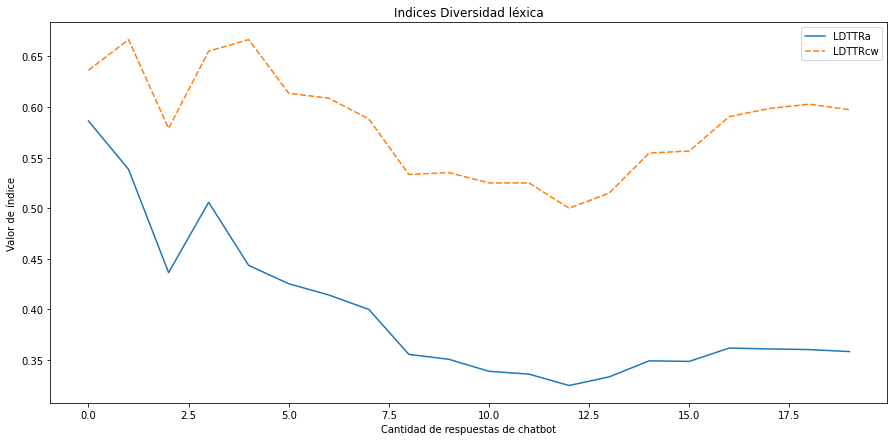

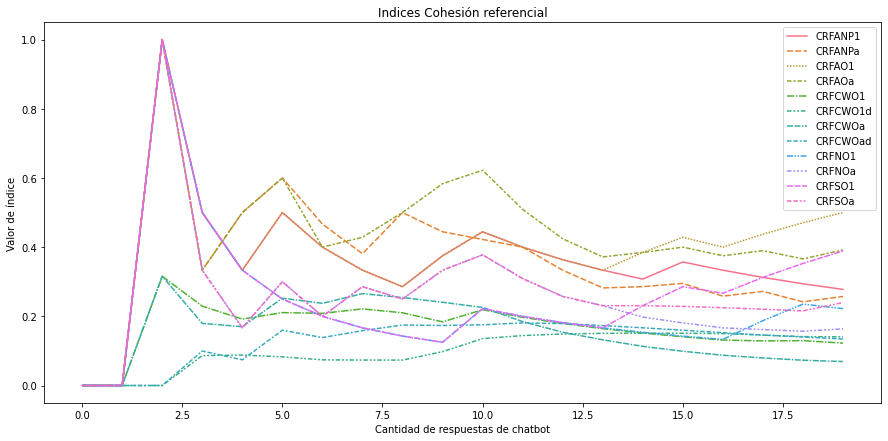

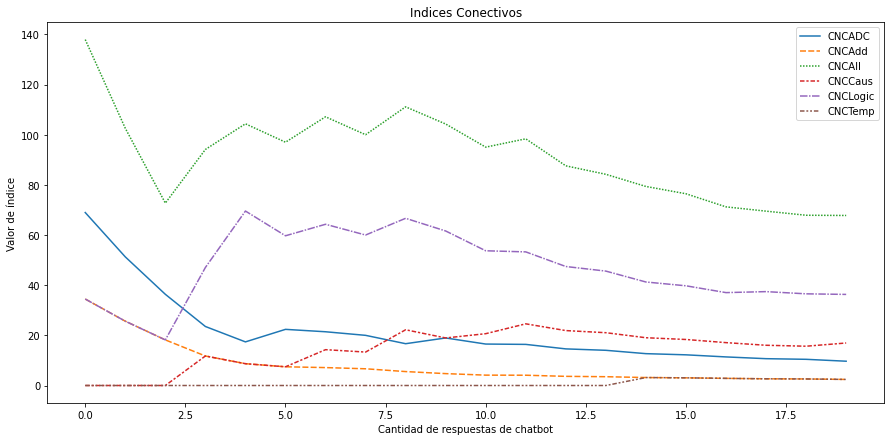

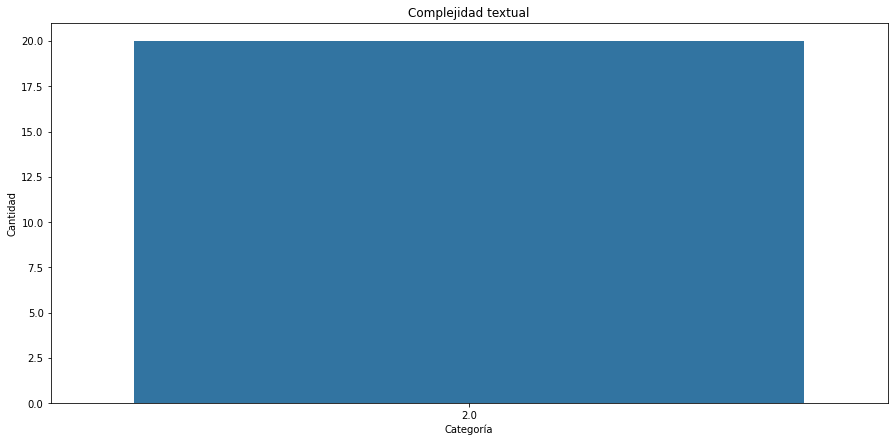

In [21]:
draw_indices(indices)

In [22]:
predicted_text_statistic_analysis(1, indices['Complejidad textual'])

La exactitud de la complejidad textual generada es 0.0%.
La media 2 es igual a 2.0. Eso significa que las respuestas generadas son de igual manera complejas y simples.


Se observa que la mayoría de las clases predichas, usando la moda como análisis, es 2, la cual es la la complejidad textual más compleja y ello se debe a que el conjunto de datos con el que se entrenó tuvo una complejidad textual de 2. Con ello, se verifica que el chatbot está produciendo respuestas adecuadas al nivel de complejidad deseado para este conjunto de datos.


# Experimento usando los documentos de Ciencia y Tecnología

## En nivel de complejidad 1

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [23]:
losses = get_training_validation_loss(f'{BASE_DIRECTORY}/data/raw/log_grade_1_CTA.txt', 100)
losses.describe()

,training,validation
count,100.000000,100.000000
mean,5.989520,7.416460
std,0.874766,0.197249
min,4.185000,7.110000
25%,5.408250,7.291000
50%,6.129000,7.383500
75%,6.618250,7.530500
max,8.723000,8.430000


#### Curva de error: Capacidad de comprensión

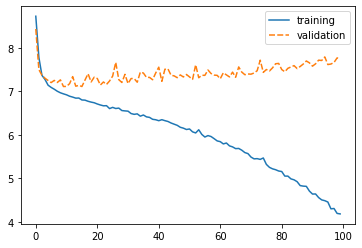

In [24]:
sns.lineplot(data=losses)
plt.show()

Se observa en la siguiente gráfica de curva de error que el chatbot, al ser entrenado con el conjunto de datos de complejidad textual 1, el cual no poseía una gran cantidad de datos para entrenar, ocasionó que el chatbot no sea tan bueno para generar respuestas a preguntas nuevas. Sin embargo, sí es capaz de reconocer aceptablemente preguntas repetidas.

#### Obteniendo las respuestas del chatbot

In [25]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_1_CTA_chat.txt')
print(chatbot_responses)

['razón niños niñas adolescentes o adultos estudiantes o trabajadores debemos promover y fortalecer garanticen garanticen cumplimiento siguientes siguientes y derecho justicia y y desarrollo peruanos peruanos', 'padres derecho libertades a escoger tipo a a a a a I I I I I I I e e e e e e e e e e z z z z', 'energía energía energía energía solar solar y sol sol sol sol energía energía energía energía energía energía energía energía energía energía energía energía energía energía energía energía energía energía energía energía y y y respondemos respondemos respondemos comunidad comunidad comunidad comunidad comunidad comunidad y comunidad comunidad comunidad comunidad comunidad comunidad comunidad comunidad comunidad comunidad y comunidad comunidad comunidad comunidad comunidad comunidad y comunidad comunidad comunidad comunidad comunidad comunidad comunidad comunidad comunidad comunidad comunidad y comunidad comunidad comunidad comunidad comunidad y comunidad comunidad comunidad comunida

#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [ ]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

#### Graficando los índices y complejidad textual

In [ ]:
draw_indices(indices)

In [ ]:
predicted_text_statistic_analysis(1, indices['Complejidad textual'])

Se observa que, utilizando la moda para encontrar la clase más con las respuestas del chatbot, el nivel de complejidad textual encontrado es de 2, en vez de 1. Ello se debe a que las respuestas del chatbot no son adecuadas, ya que el conjunto de datos provisto no fue tan grande y con ello, el chatbot no pudo descubrir los patrones correctos en los datos para generar respuestas adecuadas.

## En nivel de complejidad 2

### Resultados del entrenamiento

#### Obteniendo los datos de entrenamiento

In [ ]:
losses = get_training_validation_loss(f'{BASE_DIRECTORY}/data/raw/log_grade_2_CTA.txt', 100)
losses.describe()

#### Curva de error: Capacidad de comprensión

In [ ]:
sns.lineplot(data=losses)
plt.show()

Al entrenar el chatbot con el conjunto de datos de complejidad textual 2, el cual poseía más datos que el conjunto de complejidad textual 1, se observa que la capacidad del chatbot de comprender preguntas conocidas es mayor. Sin embargo, el modelo aún no es capaz de identificar correctamente nuevas preguntas, debido a que el valor del error en validación sigue siendo alto.

#### Obteniendo las respuestas del chatbot

In [ ]:
chatbot_responses = obtain_chatbot_responses(f'{BASE_DIRECTORY}/data/raw/log_grade_2_CTA_chat.txt')
print(chatbot_responses)

#### Analizando las respuestas del chatbot con la herramienta de análisis de complejidad textual

In [ ]:
indices = calculate_chatbots_responses_cm_indices(chatbot_responses)

#### Graficando los índices y complejidad textual

In [ ]:
draw_indices(indices)

In [ ]:
predicted_text_statistic_analysis(1, indices['Complejidad textual'])

Se observa que la mayoría de las clases predichas, usando la moda como análisis, es 2, la cual es la la complejidad textual más alta y ello se debe a que el conjunto de datos con el que se entrenó tuvo una complejidad textual de 2. Con ello, se verifica que el chatbot está produciendo respuestas adecuadas al nivel de complejidad deseado para este conjunto de datos.
